In [1]:
%load_ext autoreload
%autoreload 2
import eval_models
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 25

In [2]:
X_dig_train,X_dig_test,y_dig_train,y_dig_test=eval_models.get_train_test("digits")

## No standarization at all

In [3]:
RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_dig_train.values,y_dig_train)
X_dig_train_boruta=X_dig_train.iloc[:,feat_select.support_]
X_dig_test_boruta=X_dig_test.iloc[:,feat_select.support_]

KeyboardInterrupt: 

In [ ]:
noscaling_res=eval_models.get_models_ba(X_dig_train_boruta,
                              X_dig_test_boruta,
                              y_dig_train,
                              y_dig_test
                             )

In [ ]:
X_train_no_corr=eval_models.delete_corr(X_dig_train_boruta)#,verbose=True)

In [ ]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr,
                              X_dig_test_boruta,
                              y_dig_train,
                              y_dig_test
                             )

## Standarization after Boruta

In [ ]:
X_dig_train_boruta_sc,X_dig_test_boruta_sc=eval_models.standarize(X_dig_train_boruta,X_dig_test_boruta)

In [ ]:
X_train_no_corr2=eval_models.delete_corr(X_dig_train_boruta_sc)

In [ ]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr2,
                              X_dig_test_boruta_sc,
                              y_dig_train,
                              y_dig_test
                             )

## Standarization before Boruta

In [ ]:
X_dig_train_sc,X_dig_test_sc=eval_models.standarize(X_dig_train,X_dig_test)

In [ ]:
### (suggested max_depth between 3 and 7) podobno
RF = RandomForestClassifier(n_jobs=-1, max_depth=7)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_dig_train_sc.values,y_dig_train)
X_dig_train_sc_boruta=X_dig_train_sc.iloc[:,feat_select.support_]
X_dig_test_sc_boruta=X_dig_test_sc.iloc[:,feat_select.support_]

In [ ]:
scaled_res=eval_models.get_models_ba(X_dig_train_sc_boruta,
                              X_dig_test_sc_boruta,
                              y_dig_train,
                              y_dig_test
                             )

In [ ]:
X_dig_train_sc_no_corr=eval_models.delete_corr(X_dig_train_sc_boruta)#,verbose=True)

In [ ]:
scaled_res_cor=eval_models.get_models_ba(X_dig_train_sc_no_corr,
                              X_dig_test_sc_boruta,
                              y_dig_train,
                              y_dig_test
                             )

## Cross validation (with standarization before Boruta)

In [ ]:
kf = KFold(n_splits=5,shuffle=True)
models_res=[]
for train_idx, val_idx in tqdm(kf.split(X_dig_train)):
    X_train=X_dig_train.iloc[train_idx,:]
    X_val=X_dig_train.iloc[val_idx,:]
    y_train=y_dig_train[train_idx]
    y_val=y_dig_train[val_idx]
    
    X_train_sc,X_val_sc=eval_models.standarize(X_train,X_val)
    
    RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
    feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
    feat_select.fit(X_train.values,y_train)
    
    X_train_sc_boruta=X_train_sc.iloc[:,feat_select.support_]
    X_val_sc_boruta=X_val_sc.iloc[:,feat_select.support_]
    
    with open('../data/boruta/digits-features.csv', 'a') as f:
        np.savetxt(f, np.where(feat_select.support_), delimiter=",", fmt='%i')
    f.close()
    
    X_train_sc_boruta_no_corr=eval_models.delete_corr(X_train_sc_boruta)

    no_of_features=X_train_sc_boruta_no_corr.shape[1]
    tmp=eval_models.get_models_ba(X_train_sc_boruta_no_corr,X_val_sc_boruta,y_train,y_val)
    models_res.append(tmp)

In [ ]:
models_res.groupby(columns='Classifier').mean()

### Having run Boruta x times we will select only those variables which have been selected at least 95% of the time
remember to specify x_times! according to the number of tests you've made

In [3]:
boruta_all_results=pd.read_csv('../data/boruta/digits-features.csv',header=None,sep="\n")
boruta_all_results=boruta_all_results.iloc[:,0].str.split(',', expand=True)
x_times=boruta_all_results.shape[0]
boruta_all_array=np.array(list(filter(None, np.array(boruta_all_results).flatten()))).astype(np.int64)
unique, counts=np.unique(np.array(boruta_all_array).flatten(),return_counts=True)
columns_boruta= unique[counts>=x_times*0.95]
X_dig_train_boruta_multiple=X_dig_train.iloc[:,columns_boruta]
X_dig_train_boruta_multiple.head()

,2,12,14,16,25,34,38,48,53,66,...,4963,4966,4967,4970,4976,4977,4979,4980,4981,4991
2868,0,0,991,0,0,0,987,0,332,980,...,0,0,0,0,0,972,987,0,770,0
4630,0,645,991,0,983,0,0,0,0,983,...,991,991,0,0,0,0,662,0,0,0
1870,0,0,987,0,983,801,987,976,976,980,...,0,0,0,0,980,0,0,0,0,0
353,0,877,991,0,0,0,529,0,0,987,...,991,968,0,0,0,991,0,0,937,0
3582,0,0,0,0,831,0,0,0,0,570,...,991,991,0,0,0,874,0,0,0,0


In [5]:
eval_models.get_models_ba(X_dig_train_boruta_multiple,
                              X_dig_test,
                              y_dig_train,
                              y_dig_test,
                          n_estimators=250
                             )

LogisticRegression 0.972
RandomForestClassifier 0.9767
AdaBoostClassifier 0.9747
LGBMClassifier 0.9813
XGBClassifier 0.9807
954  features in the dataset


,Classifier,BA score
0,LogisticRegression,0.972000
1,RandomForestClassifier,0.976667
2,AdaBoostClassifier,0.974667
3,LGBMClassifier,0.981333
4,XGBClassifier,0.980667


I was impossible to run VIF on digits dataset :(

In [6]:
X_dig_train_scaled,X_dig_test_scaled=eval_models.standarize(X_dig_train,X_dig_test)
X_dig_train_scaled_boruta_multiple=X_dig_train_scaled.iloc[:,columns_boruta]

In [7]:
res_boruta_no_corr=eval_models.get_models_ba(X_dig_train_scaled_boruta_multiple,
                              X_dig_test_scaled,
                              y_dig_train,
                              y_dig_test,
                          n_estimators=250
                             )
res_boruta_no_corr['Corr']="No"

LogisticRegression 0.9753
RandomForestClassifier 0.9793
AdaBoostClassifier 0.9747
LGBMClassifier 0.9787
XGBClassifier 0.9807
954  features in the dataset


In [8]:
X_dig_train_scaled_boruta_multiple_corr=eval_models.delete_corr(X_dig_train_scaled_boruta_multiple,thresh=0.9)

In [9]:
res_boruta_yes_corr=eval_models.get_models_ba(X_dig_train_scaled_boruta_multiple_corr,
                              X_dig_test_scaled,
                              y_dig_train,
                              y_dig_test,
                          n_estimators=250)
res_boruta_yes_corr['Corr']="Yes"

LogisticRegression 0.9727
RandomForestClassifier 0.9773
AdaBoostClassifier 0.9727
LGBMClassifier 0.9807
XGBClassifier 0.9787
869  features in the dataset


In [10]:
res_boruta_all=pd.concat([res_boruta_no_corr,res_boruta_yes_corr])
res_boruta_all.sort_values(by='BA score')

,Classifier,BA score,Corr
0,LogisticRegression,0.972667,Yes
2,AdaBoostClassifier,0.972667,Yes
2,AdaBoostClassifier,0.974667,No
0,LogisticRegression,0.975333,No
1,RandomForestClassifier,0.977333,Yes
3,LGBMClassifier,0.978667,No
4,XGBClassifier,0.978667,Yes
1,RandomForestClassifier,0.979333,No
3,LGBMClassifier,0.980667,Yes
4,XGBClassifier,0.980667,No


In [11]:
res_boruta_all.replace(to_replace=['LogisticRegression','RandomForestClassifier','AdaBoostClassifier','LGBMClassifier','XGBClassifier'],value=['Logistic Regression','Random Forest','AdaBoost','LightGBM','XGBoost'],inplace=True)

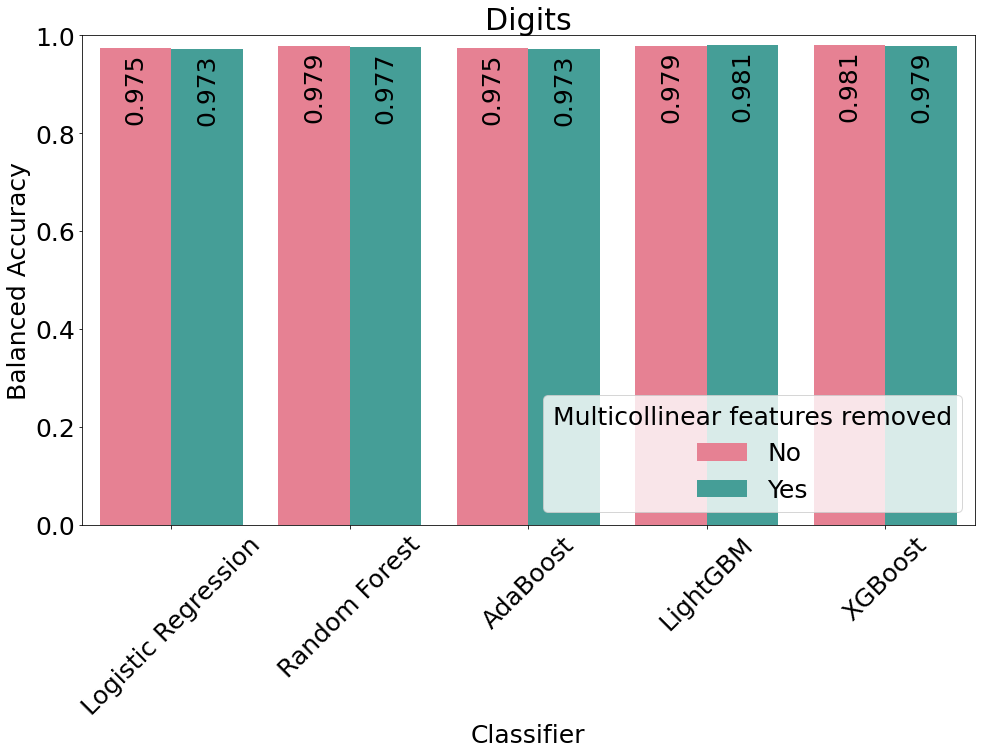

In [13]:
bars = sns.barplot(x='Classifier', y='BA score', hue='Corr', data=res_boruta_all,palette=sns.color_palette("husl", 2))
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()-0.1), ha='center', va='center', xytext=(0, 8), rotation=90,
                   textcoords='offset points')
plt.ylim(0, 1)
plt.legend(loc=4, title='Multicollinear features removed')
plt.xlabel('Classifier')
plt.ylabel('Balanced Accuracy')
plt.title('Digits')#\nClassifiers performance after Boruta feature selection')
plt.xticks(rotation=45)
plt.show()